In [1]:
from datasets import load_dataset,load_from_disk
from torch.utils.data import Dataset,DataLoader
from torch import nn

In [2]:
dataset = load_dataset('sst')

KeyboardInterrupt: 

In [2]:
dataset2 =load_dataset('multi_nli')

Found cached dataset multi_nli (/home/soumodiptab/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
dataset2.save_to_disk('multi_nli.hf')

Saving the dataset (0/1 shards):   0%|          | 0/392702 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9815 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9832 [00:00<?, ? examples/s]

In [3]:
dataset2 = load_from_disk('multi_nli.hf')

FileNotFoundError: Directory multi_nli.hf not found

In [9]:
dataset = load_from_disk('./data/sst.hf')

In [4]:
dataset2 = load_from_disk('./data/multi_nli.hf')

In [5]:
dataset2 =dataset2['train']

In [7]:
dataset2[0]

{'promptID': 31193,
 'pairID': '31193n',
 'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'premise_binary_parse': '( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )',
 'premise_parse': '(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'hypothesis_binary_parse': '( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work ) ) ) ) ) . ) )',
 'hypothesis_parse': '(ROOT (S (NP (NN Product) (CC and) (NN geography)) (VP (VBP are) (SBAR (WHNP (WP what)) (S (VP (VBP make) (NP (NP (NN cream)) (VP (VBG skimming) (NP (NN work)))))))) (. .)))',
 'genre': 'government',
 'label': 1}

In [13]:
dataset_train = dataset['train']
dataset_test = dataset['test']
dataset_val = dataset['validation']

NameError: name 'dataset' is not defined

In [14]:
import torchtext
from torchtext.data.utils import get_tokenizer
import re
from cleantext import clean
import spacy

2023-04-26 21:32:58.265976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 21:32:58.266225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Cou

In [15]:
class DataCleaner:
    def __init__(self):
        self.tokenizer = get_tokenizer('basic_english')
        self.nlp = spacy.load('en_core_web_sm', disable = ['ner', 'tagger', 'parser'])
        self.stopwords = self.nlp.Defaults.stop_words

    def replace_dates(self,text):
        date_format_a = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' <DATE> ', text)
        date_format_b = re.sub(
            r'[A-Za-z]{2,8}\s\d{1,2},?\s\d {4}', ' <DATE> ', date_format_a)
        date_format_c = re.sub(
            r'\d{2} [A-Z][a-z]{2,8} \d{4}', ' <DATE> ', date_format_b)
        return date_format_c

    def replace_hash_tags(self,text):
        return re.sub(r'(\s|^)#(\w+)', ' <HASHTAG> ', text)

    def remove_special_characters(self,text):
            # remove all special characters 
        return re.sub(r'[^A-Za-z0-9\s]', ' ', text)

    def remove_extra_spaces(self,text):
        return re.sub(r'\s{2,}', ' ', text)

    def replace_hyphenated_words(self,text):
        # replace hyphenated words with words seperated by space
        return re.sub(r'(\w+)-(\w+)', r' \1 \2 ', text)

    def clean_text(self,line):
        # line = line.strip()
        # line = re.sub(r'<|>', ' ', line)
        # line = self.replace_dates(line)
        # line = self.replace_hyphenated_words(line)
        # line = self.replace_hash_tags(line)
        # # remove < and > from the text
        # line = clean(line, no_emoji=True,
        #             no_urls=True,
        #             no_emails=True,
        #             no_phone_numbers=True,
        #             no_currency_symbols=True,           
        #             replace_with_url=" <URL> ",
        #             replace_with_email=" <EMAIL> ",
        #             replace_with_phone_number=" <PHONE> ",
        #             replace_with_currency_symbol=" <CURRENCY> ",
        #             lower=True)
        line = self.remove_special_characters(line)
        line = clean(line,no_numbers=True,
                     no_digits=True,
                     no_punct=True,
                     replace_with_number=" <NUMBER> ",
                     replace_with_digit=" ",
                     replace_with_punct="",
                     lower=True)
        line = self.remove_extra_spaces(line)
        tokens=self.tokenizer(line)
        return " ".join(tokens)
    
    def remove_stopwords(self,text):
        tokens = self.tokenizer(text)
        return " ".join([token for token in tokens if token not in self.stopwords])
    
    def lemmatize(self,text):
        doc = self.nlp(text)
        return " ".join([token.lemma_ for token in doc])
    
    def process(self,text):
        text = self.clean_text(text)
        text = self.remove_stopwords(text)
        text = self.lemmatize(text)
        return text

In [16]:
datacleaner = DataCleaner()


In [11]:
size = 0
for text in dataset_train:
    p = text['sentence'].split()
    size=max(len(p),size)
print(size)


52


In [12]:
print(dataset_train[0]["sentence"])
print(datacleaner.process(dataset_train[0]["sentence"]))

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
rock destined st century s new conan s going splash greater arnold schwarzenegger jean claud van damme steven segal


/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [17]:
from  tqdm import tqdm
from collections import Counter
import torch
import numpy as np

In [18]:
class DataPipeline(Dataset):
    def __init__(self, filename,type,max_seq_len=50,min_freq=3,vocab=None):
        self.data,self.target = self.read_data(filename,type)
        self.max_seq_len = max_seq_len
        if vocab is None:
            self.vocab, self.ind2vocab,self.word_count = self.build_vocab(self.data,min_freq)
        else:
            self.vocab = vocab
            self.ind2vocab = {v: k for k, v in vocab.items()}
            # self.word_count = self.get_word_count(vocab,self.data)
        self.ind2vocab = {ind: word for word, ind in self.vocab.items()}
        

    def get_vocab(self):
        return self.vocab
    def word_to_ind(self,word):
        if word in self.vocab:
            return self.vocab[word]
        else:
            return 1
    def ind_to_word(self,ind):
        return self.ind2vocab[ind]
    
    def read_data(self,filename,type):
        datacleaner = DataCleaner()
        data =load_from_disk(filename)
        processed_data = []
        target = []
        for line in tqdm(data[type]):
            processed_data.append(datacleaner.process(line['sentence']).split(" "))
            target.append(line['label'])
        return processed_data,target
    
    def get_word_count(self,vocab,data):
        word_count = {0: 0}
        for line in data:
            for word in line:
                if word in vocab:
                    word_count[vocab[word]] += 1
                else:
                    word_count[0] += 1
        return word_count
    
    def most_common(self,n):
        counter = Counter(self.word_count)
        common = counter.most_common(n)
        ind_freq = dict(common)
        # convert to word frequency
        word_freq = {}
        for ind in ind_freq:
            word_freq[self.ind2vocab[ind]] = ind_freq[ind]
        return word_freq
    
    @staticmethod
    def build_vocab(data,min_freq):
        word_set = {}
        print('Building vocab:')
        for line in tqdm(data):
            for word in line:
                if word not in word_set:
                    word_set[word]=1
                else:
                    word_set[word]+=1
        # sort the vocab
        word_list = sorted(list(word_set))
        word_count = {0: 0, 1: 0}
        vocab_dict = {"<pad>":0,"<unk>": 1}
        i=2
        for word in tqdm(word_list):
            if word_set[word] >= min_freq:
                vocab_dict[word] = i
                word_count[i] = word_set[word]
                i+=1
            else:
                word_count[0] += word_set[word]
        ind2word = {v: k for k, v in vocab_dict.items()}
        print('Vocab size: {}'.format(len(vocab_dict)))
        return vocab_dict, ind2word, word_count

    def total_count(self):
        return sum(self.word_count.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]
        label = self.target[idx]
        # paddding the sentences to create sequences of same length
        if len(sent) < self.max_seq_len:
            sent=[self.word_to_ind(token) for token in sent]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(sent))]
        return torch.LongTensor(sent),torch.Tensor([label])
    
    def get_batches(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=False,drop_last=True)

In [19]:
class ElmoDataset(DataPipeline):
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sent = self.data[idx]
        label = self.target[idx]
        # paddding the sentences to create sequences of same length
        if len(sent) < self.max_seq_len:
            sent=[self.word_to_ind(token) for token in sent]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(sent))]
        forward_data = sent[1:]
        backward_data = sent[:-1]
        return torch.LongTensor(forward_data),torch.LongTensor(backward_data)

In [20]:
data_train = ElmoDataset('data/sst.hf','train',80,1)

  0%|          | 0/8544 [00:00<?, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8544/8544 [00:17<00:00, 476.98it/s]


Building vocab:


100%|██████████| 14886/14886 [00:00<00:00, 1869017.82it/s]

Vocab size: 14888


In [21]:
data_validation = ElmoDataset('data/sst.hf','validation',80,1,data_train.get_vocab())

100%|██████████| 1101/1101 [00:02<00:00, 476.06it/s]


In [22]:
data_train.most_common(10)

{'s': 2612,
 'film': 1166,
 'movie': 1016,
 't': 705,
 'n': 695,
 'like': 516,
 'number': 408,
 '<': 391,
 '>': 391,
 'story': 355}

In [23]:
def load_embeddings(vocab,embeddings_file,dimension):
    # load only the embeddings that are in the vocab
    embeddings = np.zeros((len(vocab), dimension))
    with open(embeddings_file, 'r') as f:
        for line in tqdm(f):
            line = line.split()
            word = line[0]
            if word in vocab:
                embeddings[vocab[word]] = np.array(line[1:], dtype=np.float32)
    return torch.Tensor(embeddings)

In [24]:
embedding_matix=load_embeddings(data_train.get_vocab(),'embeddings/glove/glove.6B.100d.txt',100)

400000it [00:02, 195862.35it/s]


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [11]:
from matplotlib import pyplot as plt

In [36]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, max_len, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight = nn.Parameter(self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)
    def forward(self,back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out

In [25]:
elmo = ELMo(len(data_train.get_vocab()),100,100,80,embedding_matix)

In [26]:
print(elmo)

ELMo(
  (embedding): Embedding(14888, 100)
  (lstm1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear_out): Linear(in_features=200, out_features=14888, bias=True)
)


In [49]:
class ElmoTrainer:
    def __init__(self,epochs=20,lr=0.001,batch_size=50,print_every=1,device='cpu'):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.print_every = print_every
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_validation_loss = float('inf')
        self.training_loss_history = []
    
    def train(self,model : ELMo,model_save_path,train_data,validation_data):
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.training_loss_history = []
        model.to(self.device)
        for epoch in range(len(range(self.epochs))):
            model.train()
            train_loader = train_data.get_batches(self.batch_size)
            training_loss = 0
            for (forward_data,backward_data) in tqdm(train_loader):
                forward_data = forward_data.to(self.device)
                backward_data = backward_data.to(self.device)
                self.optimizer.zero_grad()
                output = model(backward_data)
                output = output.view(-1, model.vocab_size)
                target = forward_data.view(-1)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item()
            if epoch % self.print_every == 0:
                print('Training Loss : {}'.format(training_loss/len(train_loader)))
            self.__validate(model,model_save_path,validation_data)
            self.training_loss_history.append(training_loss/len(train_loader))

    def __validate(self,model:ELMo,model_save_path,validation_data):
        model.eval()
        model.to(self.device)
        validation_loader = validation_data.get_batches(self.batch_size)
        validation_loss = 0
        for i,(forward_data,backward_data) in tqdm(enumerate(validation_loader)):
            forward_data = forward_data.to(self.device)
            backward_data = backward_data.to(self.device)
            output = model(backward_data)
            output = output.view(-1, model.vocab_size)
            target = forward_data.view(-1)
            loss = self.criterion(output, target)
            validation_loss += loss.item()
        if validation_loss < self.lowest_validation_loss:
            self.lowest_validation_loss = validation_loss
            torch.save(model.state_dict(), model_save_path)
        print('Validation Loss : {}'.format(validation_loss/len(validation_loader)))

    def plot_loss(self):
        plt.plot(self.training_loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.show()

    def get_embeddings(self,model:ELMo):
        elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()
        return torch.FloatTensor(elmo_embeddings)


In [50]:
trainer = ElmoTrainer(epochs=20,lr=0.001,batch_size=50,print_every=1,device='cuda')

In [39]:
trainer.train(elmo,'model/elmo.pt',data_train,data_validation)

100%|██████████| 170/170 [00:07<00:00, 22.66it/s]


Training Loss : 1.7745419427752496


22it [00:00, 77.63it/s]


Validation Loss : 0.9795970564538782


100%|██████████| 170/170 [00:06<00:00, 28.05it/s]


Training Loss : 0.9082499596125939


22it [00:00, 78.86it/s]


Validation Loss : 0.92099944840778


100%|██████████| 170/170 [00:06<00:00, 27.82it/s]


Training Loss : 0.8746460337849224


22it [00:00, 79.48it/s]


Validation Loss : 0.8970541195435957


100%|██████████| 170/170 [00:06<00:00, 27.85it/s]


Training Loss : 0.8309116363525391


22it [00:00, 78.89it/s]


Validation Loss : 0.8541816933588549


100%|██████████| 170/170 [00:06<00:00, 27.76it/s]


Training Loss : 0.7878155721022803


22it [00:00, 77.28it/s]


Validation Loss : 0.8274129276925867


100%|██████████| 170/170 [00:06<00:00, 27.41it/s]


Training Loss : 0.7553379514199846


22it [00:00, 76.53it/s]


Validation Loss : 0.8125880333510312


100%|██████████| 170/170 [00:06<00:00, 26.61it/s]


Training Loss : 0.7269708438392948


22it [00:00, 72.70it/s]


Validation Loss : 0.7971621670506217


100%|██████████| 170/170 [00:06<00:00, 25.36it/s]


Training Loss : 0.7004017253570697


22it [00:00, 68.28it/s]


Validation Loss : 0.7792077714746649


100%|██████████| 170/170 [00:06<00:00, 25.23it/s]


Training Loss : 0.6676801468081334


22it [00:00, 71.89it/s]


Validation Loss : 0.7554730691693046


100%|██████████| 170/170 [00:06<00:00, 25.24it/s]


Training Loss : 0.6299462364876971


22it [00:00, 68.90it/s]


Validation Loss : 0.7293584265492179


100%|██████████| 170/170 [00:06<00:00, 26.23it/s]


Training Loss : 0.5930866624940844


22it [00:00, 66.96it/s]


Validation Loss : 0.7101351889696988


100%|██████████| 170/170 [00:06<00:00, 25.98it/s]


Training Loss : 0.557474860636627


22it [00:00, 71.47it/s]


Validation Loss : 0.6907598809762434


100%|██████████| 170/170 [00:06<00:00, 24.77it/s]


Training Loss : 0.521982872924384


22it [00:00, 58.32it/s]


Validation Loss : 0.6678940518335863


100%|██████████| 170/170 [00:08<00:00, 21.03it/s]


Training Loss : 0.48583143857472083


22it [00:00, 56.20it/s]


Validation Loss : 0.6477021358229897


100%|██████████| 170/170 [00:07<00:00, 21.61it/s]


Training Loss : 0.4497790640767883


22it [00:00, 70.90it/s]


Validation Loss : 0.6274086507883939


100%|██████████| 170/170 [00:06<00:00, 24.37it/s]


Training Loss : 0.41637375306557206


22it [00:00, 64.51it/s]


Validation Loss : 0.6067779619585384


100%|██████████| 170/170 [00:06<00:00, 25.10it/s]


Training Loss : 0.38568946975557244


22it [00:00, 72.52it/s]


Validation Loss : 0.5998799340291456


100%|██████████| 170/170 [00:06<00:00, 25.90it/s]


Training Loss : 0.3563544782426427


22it [00:00, 67.25it/s]


Validation Loss : 0.5754582692276348


100%|██████████| 170/170 [00:06<00:00, 25.32it/s]


Training Loss : 0.3252646508681424


22it [00:00, 70.74it/s]


Validation Loss : 0.5525653931227598


100%|██████████| 170/170 [00:06<00:00, 25.04it/s]


Training Loss : 0.2958597324569436


22it [00:00, 72.33it/s]


Validation Loss : 0.5337181755087592


In [51]:
elmo_embeddings =trainer.get_embeddings(elmo)


In [44]:
elmo_lstm1_param = elmo.lstm1
elmo_lstm2_param = elmo.lstm2

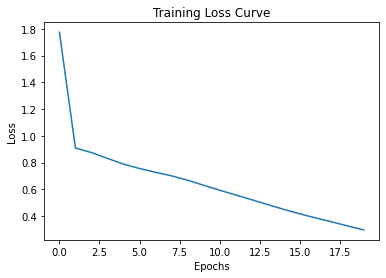

In [42]:
trainer.plot_loss()

In [115]:
class SentimentClassifier(nn.Module):
    def __init__(self,embedding_dim,hidden_dim,elmo_embeddings,elmo_l1,elmo_l2,dropout=0.2):
        super(SentimentClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(elmo_embeddings)
        self.embedding.weight = nn.Parameter(self.embedding.weight, requires_grad=True)
        self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33]), requires_grad=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.lstm1 = elmo_l1
        self.lstm2 = elmo_l2
        self.linear2 = nn.Linear(hidden_dim*2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,input_data):
        embeds = self.embedding(input_data)
        embeds_change = self.linear1(embeds)
        hidden1, _ = self.lstm1(embeds)
        hidden2, _ = self.lstm2(hidden1)
        elmo_embed = (self.weights[0]*hidden1 + self.weights[1]*hidden2 
                      + self.weights[2]*embeds_change)/(self.weights[0]+self.weights[1]+self.weights[2])
        elmo_embed_max = torch.max(elmo_embed, dim=1)[0]
        elmo_embed_max_drop = self.dropout(elmo_embed_max)
        linear_out = self.linear2(elmo_embed_max_drop)
        return torch.sigmoid(linear_out)

In [116]:
sent_train = DataPipeline('data/sst.hf','train',80,1)
sent_validation = DataPipeline('data/sst.hf','validation',80,1)

  0%|          | 0/8544 [00:00<?, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8544/8544 [00:26<00:00, 319.60it/s]


Building vocab:


100%|██████████| 14886/14886 [00:00<00:00, 703675.34it/s]


Vocab size: 14888


100%|██████████| 1101/1101 [00:04<00:00, 275.00it/s]


Building vocab:


100%|██████████| 4657/4657 [00:00<00:00, 703025.98it/s]

Vocab size: 4659


In [104]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score


In [105]:
sent_classifier = SentimentClassifier(100,100,elmo_embeddings,elmo_lstm1_param,elmo_lstm2_param)

In [106]:
class SentTrainer:
    def __init__(self,epochs=20,lr=0.001,batch_size=50,print_every=1,device='cpu'):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.print_every = print_every
        self.device = device
        self.criterion = nn.MSELoss()
        self.lowest_validation_loss = float('inf')
        self.training_loss_history = []
        self.training_accuracy_history = []
        self.training_f1_score_history = []
        self.validation_loss_history = []
    
    def train(self,model : ELMo,model_save_path,train_data,validation_data):
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.training_loss_history = []
        model.to(self.device)
        for epoch in range(len(range(self.epochs))):
            model.train()
            train_loader = train_data.get_batches(self.batch_size)
            training_loss = 0
            training_acc = 0
            training_f1 = 0
            threshold = 0.5
            for (sent_data,target) in tqdm(train_loader):
                sent_data = sent_data.to(self.device)
                target = target.to(self.device)
                self.optimizer.zero_grad()
                output = model(sent_data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item()
                true_labels = target.cpu().detach().numpy()
                pred_labels = output.cpu().detach().numpy()
                true_labels = (true_labels >= threshold).astype(np.int64)
                pred_labels = (pred_labels >= threshold).astype(np.int64)
                # get accuracy by comparing output with target and detaching from the layer
                training_acc+=accuracy_score(true_labels,pred_labels)
                training_f1+=f1_score(true_labels,pred_labels)
            if epoch % self.print_every == 0:
                print('Training Accuracy : {}'.format(training_acc/len(train_loader)))
            self.__validate(model,model_save_path,validation_data)
            self.training_loss_history.append(training_loss/len(train_loader))
            self.training_accuracy_history.append(training_acc/len(train_loader))
            self.training_f1_score_history.append(training_f1/len(train_loader))

    def __validate(self,model:ELMo,model_save_path,validation_data):
        model.eval()
        model.to(self.device)
        validation_loader = validation_data.get_batches(self.batch_size)
        validation_loss = 0
        validation_acc = 0
        validation_f1 = 0
        threshold = 0.5
        for (sent_data,target) in tqdm(validation_loader):
                sent_data = sent_data.to(self.device)
                target = target.to(self.device)
                output = model(sent_data)
                loss = self.criterion(output, target)
                validation_loss += loss.item()
                true_labels = target.cpu().detach().numpy()
                pred_labels = output.cpu().detach().numpy()
                true_labels = (true_labels >= threshold).astype(np.int64)
                pred_labels = (pred_labels >= threshold).astype(np.int64)
                validation_acc+=accuracy_score(true_labels,pred_labels)
                validation_f1+=f1_score(true_labels,pred_labels)
        if validation_loss < self.lowest_validation_loss:
            self.lowest_validation_loss = validation_loss
            torch.save(model.state_dict(), model_save_path)
        print('Validation Accuracy : {}'.format(validation_acc/len(validation_loader)))

    def plot_loss(self):
        plt.plot(self.training_loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.training_accuracy_history)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy Curve')
        plt.show()

    def plot_f1_score(self):
        plt.plot(self.training_f1_score_history)
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training F1 Score Curve')
        plt.show()

    

In [107]:
sent_trainer = SentTrainer(epochs=20,lr=0.001,batch_size=50,print_every=1,device='cuda')

In [108]:
sent_trainer.train(sent_classifier,'model/sent_classifier.pt',sent_train,sent_validation)

100%|██████████| 170/170 [00:02<00:00, 57.76it/s]


Training Accuracy : 0.8312941176470584


100%|██████████| 22/22 [00:00<00:00, 115.51it/s]


Validation Accuracy : 0.49000000000000005


100%|██████████| 170/170 [00:02<00:00, 63.96it/s]


Training Accuracy : 0.8399999999999999


100%|██████████| 22/22 [00:00<00:00, 136.53it/s]


Validation Accuracy : 0.48454545454545456


100%|██████████| 170/170 [00:02<00:00, 64.61it/s]


Training Accuracy : 0.8610588235294121


100%|██████████| 22/22 [00:00<00:00, 125.75it/s]


Validation Accuracy : 0.48363636363636364


100%|██████████| 170/170 [00:02<00:00, 62.43it/s]


Training Accuracy : 0.888352941176471


100%|██████████| 22/22 [00:00<00:00, 134.65it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 64.19it/s]


Training Accuracy : 0.9108235294117644


100%|██████████| 22/22 [00:00<00:00, 136.98it/s]


Validation Accuracy : 0.49272727272727274


100%|██████████| 170/170 [00:02<00:00, 63.65it/s]


Training Accuracy : 0.9277647058823527


100%|██████████| 22/22 [00:00<00:00, 137.59it/s]


Validation Accuracy : 0.4890909090909091


100%|██████████| 170/170 [00:02<00:00, 63.65it/s]


Training Accuracy : 0.9418823529411753


100%|██████████| 22/22 [00:00<00:00, 124.89it/s]


Validation Accuracy : 0.4918181818181818


100%|██████████| 170/170 [00:02<00:00, 61.63it/s]


Training Accuracy : 0.9469411764705876


100%|██████████| 22/22 [00:00<00:00, 138.13it/s]


Validation Accuracy : 0.4872727272727273


100%|██████████| 170/170 [00:02<00:00, 62.91it/s]


Training Accuracy : 0.9536470588235283


100%|██████████| 22/22 [00:00<00:00, 136.02it/s]


Validation Accuracy : 0.4945454545454545


100%|██████████| 170/170 [00:02<00:00, 64.34it/s]


Training Accuracy : 0.9576470588235282


100%|██████████| 22/22 [00:00<00:00, 138.56it/s]


Validation Accuracy : 0.4936363636363637


100%|██████████| 170/170 [00:02<00:00, 62.72it/s]


Training Accuracy : 0.9583529411764696


100%|██████████| 22/22 [00:00<00:00, 126.89it/s]


Validation Accuracy : 0.4936363636363636


100%|██████████| 170/170 [00:02<00:00, 61.16it/s]


Training Accuracy : 0.959764705882352


100%|██████████| 22/22 [00:00<00:00, 136.56it/s]


Validation Accuracy : 0.49090909090909085


100%|██████████| 170/170 [00:02<00:00, 64.32it/s]


Training Accuracy : 0.9610588235294112


100%|██████████| 22/22 [00:00<00:00, 129.76it/s]


Validation Accuracy : 0.4799999999999999


100%|██████████| 170/170 [00:02<00:00, 62.10it/s]


Training Accuracy : 0.9574117647058816


100%|██████████| 22/22 [00:00<00:00, 132.32it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 60.52it/s]


Training Accuracy : 0.9612941176470576


100%|██████████| 22/22 [00:00<00:00, 126.70it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 63.48it/s]


Training Accuracy : 0.9612941176470583


100%|██████████| 22/22 [00:00<00:00, 128.62it/s]


Validation Accuracy : 0.4836363636363636


100%|██████████| 170/170 [00:02<00:00, 62.48it/s]


Training Accuracy : 0.9671764705882347


100%|██████████| 22/22 [00:00<00:00, 131.82it/s]


Validation Accuracy : 0.48636363636363633


100%|██████████| 170/170 [00:02<00:00, 61.67it/s]


Training Accuracy : 0.9647058823529405


100%|██████████| 22/22 [00:00<00:00, 104.66it/s]


Validation Accuracy : 0.48545454545454536


100%|██████████| 170/170 [00:03<00:00, 53.44it/s]


Training Accuracy : 0.9598823529411759


100%|██████████| 22/22 [00:00<00:00, 104.83it/s]


Validation Accuracy : 0.4799999999999999


100%|██████████| 170/170 [00:03<00:00, 51.59it/s]


Training Accuracy : 0.9570588235294112


100%|██████████| 22/22 [00:00<00:00, 104.84it/s]

Validation Accuracy : 0.49


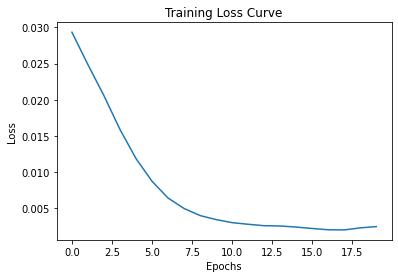

In [111]:
sent_trainer.plot_loss()

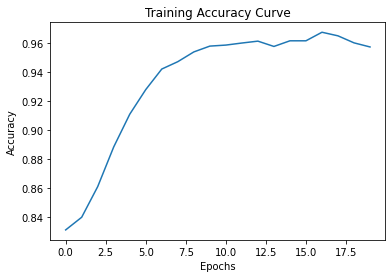

In [112]:
sent_trainer.plot_accuracy()

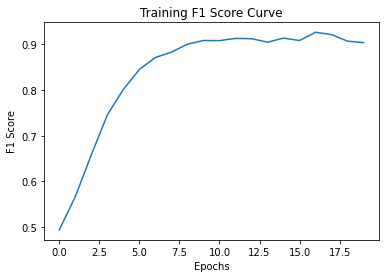

In [113]:
sent_trainer.plot_f1_score()